# 2a — Object Detection: RF-DETR

**Method implemented in this notebook:**  
- **RF-DETR** (PyTorch)

## Project dataset structure
- `./signs.json` (original consolidated annotations at project root)
- `./signs_coco/images/` (all images, `.jpg` / `.jpeg`)
- `./signs_coco/result.json` (COCO-format annotations)

## What this notebook does
1. Environment + deterministic setup  
2. Load COCO dataset, sanity-check classes + samples  
3. Create a deterministic train/val split + write COCO JSONs (for RF-DETR)  
4. Train **RF-DETR** object detector  
5. Evaluate (mAP, qualitative predictions, per-class metrics)  
6. Save checkpoint + export inference helper  
7. Quick end-to-end demo on a sample image  

In [5]:
from pathlib import Path
import os, sys, json, random
import numpy as np

import torch
import torchvision

print("Python:", sys.version.split()[0])
print("Torch:", torch.__version__)
print("TorchVision:", torchvision.__version__)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
if device.type == "cuda":
    print("CUDA:", torch.version.cuda)
    print("GPU:", torch.cuda.get_device_name(0))

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

PROJECT_ROOT = Path(".").resolve()
COCO_ANN = PROJECT_ROOT / "signs_coco" / "result.json"
IMAGES_DIR = PROJECT_ROOT / "signs_coco" / "images"

assert COCO_ANN.exists(), f"Missing COCO annotations: {COCO_ANN}"
assert IMAGES_DIR.exists(), f"Missing images folder: {IMAGES_DIR}"

print("PROJECT_ROOT:", PROJECT_ROOT)
print("COCO_ANN:", COCO_ANN)
print("IMAGES_DIR:", IMAGES_DIR)

img_files = sorted([p for p in IMAGES_DIR.iterdir() if p.suffix.lower() in [".jpg", ".jpeg"]])
print("Images found:", len(img_files))
print("Example image:", img_files[0].name if img_files else "N/A")

Python: 3.11.14
Torch: 2.8.0+cu128
TorchVision: 0.23.0+cu128
Device: cuda
CUDA: 12.8
GPU: NVIDIA GeForce RTX 2070 SUPER
PROJECT_ROOT: /home/yukkami/cv
COCO_ANN: /home/yukkami/cv/signs_coco/result.json
IMAGES_DIR: /home/yukkami/cv/signs_coco/images
Images found: 602
Example image: 002c644e-Pre_2026_6761.jpg


In [6]:
from collections import defaultdict, Counter

with open(COCO_ANN, "r", encoding="utf-8") as f:
    coco = json.load(f)

print("Top-level keys:", list(coco.keys()))

images = coco.get("images", [])
annotations = coco.get("annotations", [])
categories = coco.get("categories", [])

print(f"#images: {len(images)}")
print(f"#annotations: {len(annotations)}")
print(f"#categories: {len(categories)}")

cat_id_to_name = {c["id"]: c["name"] for c in categories}
cat_name_to_id = {c["name"]: c["id"] for c in categories}

print("\nFirst 10 categories:")
for c in categories[:10]:
    print(f'  id={c["id"]:<4} name="{c["name"]}"')

ann_counts = Counter([a["category_id"] for a in annotations])
top = ann_counts.most_common(10)
print("\nTop 10 categories by annotation count:")
for cid, cnt in top:
    print(f'  {cat_id_to_name.get(cid, str(cid)):<30} {cnt}')

bad = 0
for a in annotations[:5000]:
    x, y, w, h = a["bbox"]
    if w <= 0 or h <= 0:
        bad += 1
print("\nBBox sanity (sampled): bad bboxes =", bad)

img_id_to_file = {im["id"]: im["file_name"] for im in images}
print("Example mapping:", next(iter(img_id_to_file.items())) if img_id_to_file else "N/A")

Top-level keys: ['images', 'categories', 'annotations', 'info']
#images: 602
#annotations: 899
#categories: 38

First 10 categories:
  id=0    name="Animal"
  id=1    name="Back"
  id=2    name="Blind-Spot Mirror (Convex)"
  id=3    name="Bump"
  id=4    name="Circular"
  id=5    name="Damaged"
  id=6    name="Front"
  id=7    name="Give way"
  id=8    name="Good"
  id=9    name="Heavily Damaged"

Top 10 categories by annotation count:
  No Entry (One Way)             179
  Pedestrian Crossing            122
  Stop                           92
  Blind-Spot Mirror (Convex)     85
  No Turn (left/right)           67
  Turn (left/right)              62
  Speed Limit                    52
  Roundabout Ahead               45
  No Stopping                    41
  Give way                       38

BBox sanity (sampled): bad bboxes = 0
Example mapping: (0, '../../label-studio/data/media/upload/3/5cc76983-IMG_20251125_190933.jpg')


Images with >=1 annotation: 602


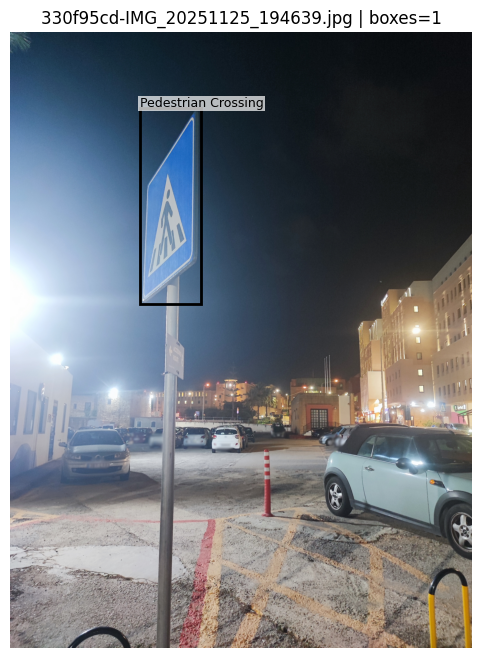

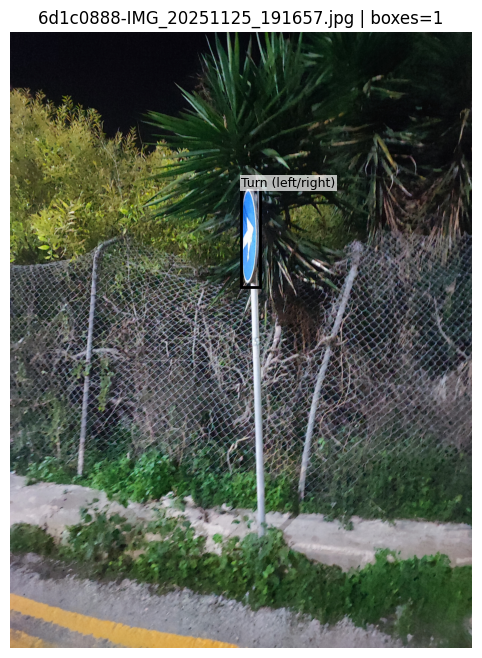

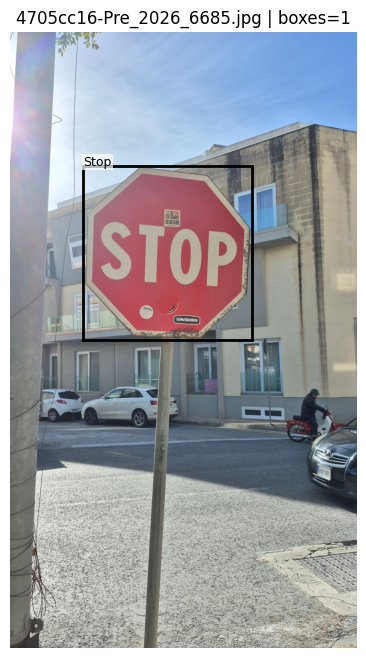

In [7]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

img_to_anns = defaultdict(list)
for a in annotations:
    img_to_anns[a["image_id"]].append(a)

def show_coco_sample(image_id, figsize=(10, 8), max_boxes=30):
    file_name = img_id_to_file[image_id]
    img_path = IMAGES_DIR / file_name
    if not img_path.exists():
        img_path = IMAGES_DIR / Path(file_name).name
    assert img_path.exists(), f"Image not found: {img_path}"

    img = Image.open(img_path).convert("RGB")
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.imshow(img)
    ax.axis("off")

    anns = img_to_anns.get(image_id, [])[:max_boxes]
    for ann in anns:
        x, y, w, h = ann["bbox"]
        cid = ann["category_id"]
        label = cat_id_to_name.get(cid, str(cid))

        rect = patches.Rectangle((x, y), w, h, linewidth=2, fill=False)
        ax.add_patch(rect)
        ax.text(
            x, max(0, y - 3),
            label,
            fontsize=9,
            bbox=dict(facecolor="white", alpha=0.7, edgecolor="none", pad=1),
        )

    ax.set_title(f"{img_path.name} | boxes={len(anns)}", fontsize=12)
    plt.show()

image_ids_with_anns = [im["id"] for im in images if im["id"] in img_to_anns and len(img_to_anns[im["id"]]) > 0]
print("Images with >=1 annotation:", len(image_ids_with_anns))

for _ in range(3):
    iid = random.choice(image_ids_with_anns)
    show_coco_sample(iid)

from PIL import ImageDraw, ImageFont

def draw_predictions(
    img_path,
    preds,
    score_thr=0.3,
    save_path=None,
    rfdetr_model_for_names=None,
    coco_json_for_names=None,
    resize_to=None,
    font_scale=0.06,
):
    img = Image.open(img_path).convert("RGB")
    w0, h0 = img.size

    if resize_to is not None:
        w1, h1 = int(resize_to[0]), int(resize_to[1])
        sx, sy = w1 / w0, h1 / h0
        img = img.resize((w1, h1), resample=Image.BILINEAR)
    else:
        sx = sy = 1.0

    id_to_name = {}
    if coco_json_for_names is not None:
        try:
            with open(coco_json_for_names, "r", encoding="utf-8") as f:
                _c = json.load(f)
            for c in _c.get("categories", []):
                if isinstance(c, dict) and "id" in c and "name" in c:
                    id_to_name[int(c["id"])] = str(c["name"])
        except Exception:
            pass

    xyxy = getattr(preds, "xyxy", None)
    conf = getattr(preds, "confidence", None)
    cls  = getattr(preds, "class_id", None)

    if xyxy is None or cls is None:
        if save_path is not None:
            img.save(save_path)
        return img

    xyxy = np.asarray(xyxy)
    cls = np.asarray(cls).astype(int)
    if conf is None:
        conf = np.ones((len(xyxy),), dtype=float)
    else:
        conf = np.asarray(conf).astype(float)

    draw = ImageDraw.Draw(img)
    try:
        font_size = max(10, int(min(img.size) * float(font_scale)))
        font = ImageFont.truetype("DejaVuSans.ttf", font_size)
    except Exception:
        font = ImageFont.load_default()

    for (x1, y1, x2, y2), c, s in zip(xyxy, cls, conf):
        if float(s) < float(score_thr):
            continue
        x1, y1, x2, y2 = float(x1) * sx, float(y1) * sy, float(x2) * sx, float(y2) * sy
        draw.rectangle([x1, y1, x2, y2], outline="red", width=3)
        name = id_to_name.get(int(c), cat_id_to_name.get(int(c), str(int(c))))
        label = f"{name} {float(s):.2f}"
        tx, ty = x1, max(0, y1 - 14)
        draw.rectangle([tx, ty, tx + 8 * len(label), ty + 14], fill=(255, 255, 255))
        draw.text((tx + 2, ty + 1), label, fill="black", font=font)

    if save_path is not None:
        Path(save_path).parent.mkdir(parents=True, exist_ok=True)
        img.save(save_path)

    return img

In [8]:
SPLIT_SEED = 42
TRAIN_FRACTION = 0.8

run_dir = PROJECT_ROOT / "runs" / f"2a_rfdetr"
split_dir = run_dir / "splits"
split_dir.mkdir(parents=True, exist_ok=True)

train_json_path = split_dir / "train_coco.json"
val_json_path   = split_dir / "val_coco.json"

rng = np.random.default_rng(SPLIT_SEED)
all_images = list(images)
rng.shuffle(all_images)

n_train = int(len(all_images) * TRAIN_FRACTION)
train_images = all_images[:n_train]
val_images   = all_images[n_train:]

train_img_ids = set(im["id"] for im in train_images)
val_img_ids   = set(im["id"] for im in val_images)

train_anns = [a for a in annotations if a["image_id"] in train_img_ids]
val_anns   = [a for a in annotations if a["image_id"] in val_img_ids]

def write_coco_subset(out_path: Path, subset_images, subset_anns, categories, coco_info=None, coco_licenses=None):
    subset = {
        "images": subset_images,
        "annotations": subset_anns,
        "categories": categories,
    }
    if coco_info is not None:
        subset["info"] = coco_info
    if coco_licenses is not None:
        subset["licenses"] = coco_licenses

    with open(out_path, "w", encoding="utf-8") as f:
        json.dump(subset, f)
    return subset

train_subset = write_coco_subset(
    train_json_path, train_images, train_anns, categories,
    coco_info=coco.get("info"), coco_licenses=coco.get("licenses")
)
val_subset = write_coco_subset(
    val_json_path, val_images, val_anns, categories,
    coco_info=coco.get("info"), coco_licenses=coco.get("licenses")
)

print("Run dir:", run_dir)
print("Train JSON:", train_json_path, "| images:", len(train_images), "| anns:", len(train_anns))
print("Val   JSON:", val_json_path,   "| images:", len(val_images),   "| anns:", len(val_anns))

train_counts = Counter([a["category_id"] for a in train_anns]).most_common(10)
val_counts   = Counter([a["category_id"] for a in val_anns]).most_common(10)

print("\nTop-10 classes in TRAIN:")
for cid, cnt in train_counts:
    print(f"  {cat_id_to_name.get(cid, cid):<30} {cnt}")

print("\nTop-10 classes in VAL:")
for cid, cnt in val_counts:
    print(f"  {cat_id_to_name.get(cid, cid):<30} {cnt}")

Run dir: /home/yukkami/cv/runs/2a_rfdetr
Train JSON: /home/yukkami/cv/runs/2a_rfdetr/splits/train_coco.json | images: 481 | anns: 726
Val   JSON: /home/yukkami/cv/runs/2a_rfdetr/splits/val_coco.json | images: 121 | anns: 173

Top-10 classes in TRAIN:
  No Entry (One Way)             143
  Pedestrian Crossing            94
  Stop                           75
  Blind-Spot Mirror (Convex)     73
  Turn (left/right)              53
  No Turn (left/right)           50
  Speed Limit                    45
  No Stopping                    36
  Roundabout Ahead               35
  Give way                       27

Top-10 classes in VAL:
  No Entry (One Way)             36
  Pedestrian Crossing            28
  No Turn (left/right)           17
  Stop                           17
  Blind-Spot Mirror (Convex)     12
  Give way                       11
  Roundabout Ahead               10
  Turn (left/right)              9
  No Through Road (T-sign)       8
  Speed Limit                    7


In [9]:
def normalize_coco_filenames(coco_json_path: Path, images_dir: Path) -> int:
    with open(coco_json_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    updated = 0
    missing = []

    for im in data.get("images", []):
        fn = im.get("file_name", "")
        p1 = images_dir / fn
        if p1.exists():
            continue

        base = Path(fn).name
        p2 = images_dir / base
        if p2.exists():
            im["file_name"] = base
            updated += 1
        else:
            missing.append(fn)

    if missing:
        print(f"[WARN] {len(missing)} image files referenced but not found under {images_dir}")
        print("First 10 missing examples:", missing[:10])

    with open(coco_json_path, "w", encoding="utf-8") as f:
        json.dump(data, f)

    return updated

u_train = normalize_coco_filenames(train_json_path, IMAGES_DIR)
u_val   = normalize_coco_filenames(val_json_path, IMAGES_DIR)

print("Updated file_name entries -> TRAIN:", u_train, "| VAL:", u_val)

with open(train_json_path, "r", encoding="utf-8") as f:
    _train = json.load(f)
print("Example train file_names:", [im["file_name"] for im in _train["images"][:5]])

sorted_cat_ids = sorted([c["id"] for c in categories])
coco_cat_id_to_contig = {cid: i + 1 for i, cid in enumerate(sorted_cat_ids)}
contig_to_name = {i + 1: cat_id_to_name[cid] for i, cid in enumerate(sorted_cat_ids)}
NUM_CLASSES = len(sorted_cat_ids) + 1

print("NUM_CLASSES (incl background):", NUM_CLASSES)
print("Example mapping COCO->contig:", list(coco_cat_id_to_contig.items())[:5])

Updated file_name entries -> TRAIN: 481 | VAL: 121
Example train file_names: ['24b674c2-Pre_2026_6609.jpg', 'c89e8b4a-IMG_1368.jpg', '89530c81-IMG_20251125_194913.jpg', 'bd271b5d-IMG_1401.jpg', 'f09e9bf4-Pre_2026_6657.jpg']
NUM_CLASSES (incl background): 39
Example mapping COCO->contig: [(0, 1), (1, 2), (2, 3), (3, 4), (4, 5)]


In [10]:
import os
import json
import shutil
import tempfile
from pathlib import Path

os.environ["TMPDIR"] = "/tmp"
os.environ["TMP"]    = "/tmp"
os.environ["TEMP"]   = "/tmp"
tempfile.tempdir     = "/tmp"

rfdetr_root = run_dir / "rfdetr_data"
rfdetr_train = rfdetr_root / "train"
rfdetr_valid = rfdetr_root / "valid"
rfdetr_test  = rfdetr_root / "test"

for p in [rfdetr_train, rfdetr_valid, rfdetr_test]:
    p.mkdir(parents=True, exist_ok=True)

def _safe_link_or_copy(src: Path, dst: Path):
    dst.parent.mkdir(parents=True, exist_ok=True)
    if dst.exists():
        return
    try:
        os.symlink(src.resolve(), dst)
    except Exception:
        shutil.copy2(src, dst)

def _materialize_split(split_json_path: Path, out_dir: Path):
    ann_out = out_dir / "_annotations.coco.json"
    shutil.copy2(split_json_path, ann_out)

    with open(split_json_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    missing = 0
    for im in data.get("images", []):
        fn = im["file_name"]
        src = IMAGES_DIR / fn
        if not src.exists():
            src = IMAGES_DIR / Path(fn).name
        if not src.exists():
            missing += 1
            continue
        dst = out_dir / Path(src).name
        _safe_link_or_copy(src, dst)

    return len(data.get("images", [])), missing

n_tr, miss_tr = _materialize_split(train_json_path, rfdetr_train)
n_va, miss_va = _materialize_split(val_json_path, rfdetr_valid)
n_te, miss_te = _materialize_split(val_json_path, rfdetr_test)

print("RF-DETR dataset created at:", rfdetr_root)
print(f"  train: {n_tr} images | missing on disk: {miss_tr}")
print(f"  valid: {n_va} images | missing on disk: {miss_va}")
print(f"  test : {n_te} images | missing on disk: {miss_te}")

RF-DETR dataset created at: /home/yukkami/cv/runs/2a_rfdetr/rfdetr_data
  train: 481 images | missing on disk: 0
  valid: 121 images | missing on disk: 0
  test : 121 images | missing on disk: 0


## RF-DETR training

Uses `rfdetr_root/{train,valid,test}` (each split has `_annotations.coco.json` + images).

Outputs go to `run_dir / "rfdetr_outputs"`.

In [11]:
from pathlib import Path
from importlib.metadata import version as pkg_version
from importlib.util import find_spec
import os, gc, json
import torch
import torch.nn as nn

torch.set_grad_enabled(True)
print("Autograd enabled at start of RF-DETR cell:", torch.is_grad_enabled())

os.environ.setdefault("PYTORCH_CUDA_ALLOC_CONF", "expandable_segments:True,max_split_size_mb:128")

if find_spec("cv2") is None:
    raise ImportError(
        "Missing module 'cv2'. This comes from OpenCV.\n"
        "Fix: ensure your environment installs opencv-python-headless.\n"
    )

def gpu_mem():
    if torch.cuda.is_available():
        free, total = torch.cuda.mem_get_info()
        return free / (1024**3), total / (1024**3)
    return None, None

def cleanup_cuda():
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.ipc_collect()

if device.type == "cuda":
    free_gb, total_gb = gpu_mem()
    print(f"GPU mem (before): free={free_gb:.2f}GB / total={total_gb:.2f}GB")
else:
    free_gb, total_gb = (None, None)

FORCE_VARIANT = None
FORCE_RES     = None

default_variant = "nano" if (device.type == "cuda" and (total_gb is not None and total_gb <= 8.5)) else "small"
default_res     = 448 if (device.type == "cuda" and (total_gb is not None and total_gb <= 8.5)) else 560

RFDETR_VARIANT = FORCE_VARIANT or default_variant
RFDETR_EPOCHS  = 15
RFDETR_LR      = 1e-4
RFDETR_RESOLUTION = FORCE_RES or default_res

if RFDETR_RESOLUTION % 56 != 0:
    raise ValueError(f"RFDETR_RESOLUTION must be divisible by 56, got {RFDETR_RESOLUTION}")

if device.type == "cuda":
    RFDETR_BATCH_SIZE = 1
    RFDETR_GRAD_ACCUM = 16
else:
    RFDETR_BATCH_SIZE = 2
    RFDETR_GRAD_ACCUM = 8

rfdetr_out = run_dir / "rfdetr_outputs"
rfdetr_out.mkdir(parents=True, exist_ok=True)

print("RF-DETR dataset_dir:", rfdetr_root)
print("RF-DETR output_dir :", rfdetr_out)
print("Requested variant  :", RFDETR_VARIANT)
print("epochs:", RFDETR_EPOCHS, "| batch_size:", RFDETR_BATCH_SIZE, "| grad_accum:", RFDETR_GRAD_ACCUM)
print("lr:", RFDETR_LR, "| resolution:", RFDETR_RESOLUTION)

def ensure_supercategory_in_coco_json(coco_path: Path, default_supercategory: str = "sign") -> int:
    if not coco_path.exists():
        return 0
    with open(coco_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    cats = data.get("categories", [])
    if not isinstance(cats, list):
        return 0

    changed = 0
    for c in cats:
        if isinstance(c, dict) and "supercategory" not in c:
            name = str(c.get("name", "")).strip().lower()
            c["supercategory"] = "none" if name == "none" else default_supercategory
            changed += 1

    if changed:
        with open(coco_path, "w", encoding="utf-8") as f:
            json.dump(data, f, ensure_ascii=False, indent=2)

    return changed

anno_files = [
    Path(rfdetr_root) / "train" / "_annotations.coco.json",
    Path(rfdetr_root) / "valid" / "_annotations.coco.json",
    Path(rfdetr_root) / "test"  / "_annotations.coco.json",
]
for p in anno_files:
    c = ensure_supercategory_in_coco_json(p, default_supercategory="sign")
    print(f"{'Patched' if c else 'OK'} {p} ({c} changes)")

try:
    import rfdetr
    print("Installed rfdetr version:", pkg_version("rfdetr"))
except Exception as e:
    raise ImportError("Failed to import rfdetr.\n" f"Original error: {repr(e)}")

available = sorted([n for n in dir(rfdetr) if n.startswith("RFDETR")])
print("RFDETR symbols available:", available)

variant_to_classname = {
    "nano": "RFDETRNano",
    "small": "RFDETRSmall",
    "base": "RFDETRBase",
    "medium": "RFDETRMedium",
    "large": "RFDETRLarge",
    "xlarge": "RFDETRXLarge",
    "2xlarge": "RFDETR2XLarge",
}

def safe_enable_grad_checkpointing(root_obj) -> bool:
    import functools
    from torch.utils.checkpoint import checkpoint as torch_checkpoint

    try:
        ckpt_fn = functools.partial(torch_checkpoint, use_reentrant=False)
    except TypeError:
        ckpt_fn = torch_checkpoint

    enabled = False
    seen = set()
    stack = [root_obj]

    def patch_module(m: nn.Module):
        nonlocal enabled

        if hasattr(m, "gradient_checkpointing_enable"):
            try:
                m.gradient_checkpointing_enable()
                enabled = True
            except Exception:
                pass

        for sub in m.modules():
            if hasattr(sub, "gradient_checkpointing"):
                try:
                    setattr(sub, "gradient_checkpointing", True)
                    enabled = True
                except Exception:
                    pass

                try:
                    if getattr(sub, "gradient_checkpointing", False) and not hasattr(sub, "_gradient_checkpointing_func"):
                        setattr(sub, "_gradient_checkpointing_func", ckpt_fn)
                        enabled = True
                except Exception:
                    pass

    while stack:
        x = stack.pop()
        xid = id(x)
        if xid in seen:
            continue
        seen.add(xid)

        if isinstance(x, nn.Module):
            patch_module(x)
            continue

        for attr in ("model", "module", "net", "backbone", "encoder", "transformer"):
            if hasattr(x, attr):
                try:
                    v = getattr(x, attr)
                    if v is not None:
                        stack.append(v)
                except Exception:
                    pass

        if hasattr(x, "__dict__"):
            for v in list(x.__dict__.values())[:80]:
                if isinstance(v, nn.Module):
                    stack.append(v)
                elif hasattr(v, "__dict__"):
                    stack.append(v)

    return enabled

attempts = [
    (RFDETR_VARIANT, RFDETR_RESOLUTION, RFDETR_BATCH_SIZE, RFDETR_GRAD_ACCUM),
    ("nano", 448, 1, 16),
    ("nano", 392, 1, 16),
    ("nano", 336, 1, 16),
]

last_err = None

for (variant, res, bs, accum) in attempts:
    if res % 56 != 0:
        continue

    print("\n==============================")
    print(f"Attempt: variant={variant} | res={res} | batch={bs} | grad_accum={accum}")
    print("==============================")

    cleanup_cuda()
    if device.type == "cuda":
        free_gb, total_gb = gpu_mem()
        print(f"GPU mem (pre-attempt): free={free_gb:.2f}GB / total={total_gb:.2f}GB")

    cname = variant_to_classname.get(variant.lower())
    if cname is None or not hasattr(rfdetr, cname):
        print(f"Skipping: class for variant '{variant}' not available")
        continue

    try:
        torch.set_grad_enabled(True)
        print("Autograd enabled pre-train:", torch.is_grad_enabled())

        rfdetr_model = getattr(rfdetr, cname)()

        ckpt_on = safe_enable_grad_checkpointing(rfdetr_model)
        print("Gradient checkpointing enabled (safe):", ckpt_on)

        with torch.enable_grad():
            rfdetr_model.train(
                dataset_dir=str(rfdetr_root),
                output_dir=str(rfdetr_out),
                epochs=RFDETR_EPOCHS,
                batch_size=bs,
                grad_accum_steps=accum,
                lr=RFDETR_LR,
                resolution=res,
                early_stopping=True,
            )

        print("\nRF-DETR training finished.")
        print("Artifacts saved to:", rfdetr_out)
        break

    except torch.cuda.OutOfMemoryError as e:
        last_err = e
        print("\nCUDA OOM on this attempt.")
        print("Error:", repr(e))
        try:
            del rfdetr_model
        except Exception:
            pass
        cleanup_cuda()
        continue

    except Exception:
        raise

else:
    raise RuntimeError(
        "All RF-DETR attempts failed due to CUDA OOM.\n"
        "Next steps: close other GPU processes (nvidia-smi), or train on CPU.\n"
        f"Last error: {repr(last_err)}"
    )

Autograd enabled at start of RF-DETR cell: True
GPU mem (before): free=6.27GB / total=7.77GB
RF-DETR dataset_dir: /home/yukkami/cv/runs/2a_rfdetr/rfdetr_data
RF-DETR output_dir : /home/yukkami/cv/runs/2a_rfdetr/rfdetr_outputs
Requested variant  : nano
epochs: 15 | batch_size: 1 | grad_accum: 16
lr: 0.0001 | resolution: 448
Patched /home/yukkami/cv/runs/2a_rfdetr/rfdetr_data/train/_annotations.coco.json (38 changes)
Patched /home/yukkami/cv/runs/2a_rfdetr/rfdetr_data/valid/_annotations.coco.json (38 changes)
Patched /home/yukkami/cv/runs/2a_rfdetr/rfdetr_data/test/_annotations.coco.json (38 changes)
Installed rfdetr version: 1.4.0.post0
RFDETR symbols available: ['RFDETR2XLarge', 'RFDETRBase', 'RFDETRLarge', 'RFDETRLargeDeprecated', 'RFDETRMedium', 'RFDETRNano', 'RFDETRSeg2XLarge', 'RFDETRSegLarge', 'RFDETRSegMedium', 'RFDETRSegNano', 'RFDETRSegPreview', 'RFDETRSegSmall', 'RFDETRSegXLarge', 'RFDETRSmall', 'RFDETRXLarge']

Attempt: variant=nano | res=448 | batch=1 | grad_accum=16
GPU mem

rf-detr-nano.pth: 100%|██████████| 349M/349M [00:10<00:00, 36.3MiB/s] 


Using a different number of positional encodings than DINOv2, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
Using patch size 16 instead of 14, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
Loading pretrain weights
Gradient checkpointing enabled (safe): True
Unable to initialize TensorBoard. Logging is turned off for this session.  Run 'pip install tensorboard' to enable logging.
Not using distributed mode
git:
  sha: b12c2d4d09aa8a3e659c737a0603c2bf976ef99d, status: has uncommited changes, branch: andrew

Namespace(num_classes=39, grad_accum_steps=16, amp=True, lr=0.0001, lr_encoder=0.00015, batch_size=1, weight_decay=0.0001, epochs=15, lr_drop=100, clip_max_norm=0.1, lr_vit_layer_decay=0.8, lr_component_decay=0.7, do_benchmark=False, dropout=0, drop_path=0.0, drop_mode='standard', drop_schedule='constant', cutoff_epoch=0, pretrained_encoder=

Epoch: [0]  [ 0/30]  eta: 0:03:20  lr: 0.000100  class_error: 100.00  loss: 30.1420 (30.1420)  loss_ce: 9.9995 (9.9995)  loss_bbox: 0.0396 (0.0396)  loss_giou: 0.0468 (0.0468)  loss_ce_0: 9.5829 (9.5829)  loss_bbox_0: 0.0960 (0.0960)  loss_giou_0: 0.0917 (0.0917)  loss_ce_enc: 9.7588 (9.7588)  loss_bbox_enc: 0.2578 (0.2578)  loss_giou_enc: 0.2690 (0.2690)  loss_ce_unscaled: 9.9995 (9.9995)  class_error_unscaled: 100.0000 (100.0000)  loss_bbox_unscaled: 0.0079 (0.0079)  loss_giou_unscaled: 0.0234 (0.0234)  cardinality_error_unscaled: 3899.0000 (3899.0000)  loss_ce_0_unscaled: 9.5829 (9.5829)  loss_bbox_0_unscaled: 0.0192 (0.0192)  loss_giou_0_unscaled: 0.0458 (0.0458)  cardinality_error_0_unscaled: 3898.0000 (3898.0000)  loss_ce_enc_unscaled: 9.7588 (9.7588)  loss_bbox_enc_unscaled: 0.0516 (0.0516)  loss_giou_enc_unscaled: 0.1345 (0.1345)  cardinality_error_enc_unscaled: 3899.0000 (3899.0000)  time: 6.6939  data: 2.6894  max mem: 801
Epoch: [0]  [10/30]  eta: 0:01:09  lr: 0.000100  clas

Test:  [  0/121]  eta: 0:00:44  class_error: 50.00  loss: 4.1915 (4.1915)  loss_ce: 1.1953 (1.1953)  loss_bbox: 0.0280 (0.0280)  loss_giou: 0.0730 (0.0730)  loss_ce_0: 1.2812 (1.2812)  loss_bbox_0: 0.0358 (0.0358)  loss_giou_0: 0.0866 (0.0866)  loss_ce_enc: 1.1953 (1.1953)  loss_bbox_enc: 0.1120 (0.1120)  loss_giou_enc: 0.1842 (0.1842)  loss_ce_unscaled: 1.1953 (1.1953)  class_error_unscaled: 50.0000 (50.0000)  loss_bbox_unscaled: 0.0056 (0.0056)  loss_giou_unscaled: 0.0365 (0.0365)  cardinality_error_unscaled: 298.0000 (298.0000)  loss_ce_0_unscaled: 1.2812 (1.2812)  loss_bbox_0_unscaled: 0.0072 (0.0072)  loss_giou_0_unscaled: 0.0433 (0.0433)  cardinality_error_0_unscaled: 298.0000 (298.0000)  loss_ce_enc_unscaled: 1.1953 (1.1953)  loss_bbox_enc_unscaled: 0.0224 (0.0224)  loss_giou_enc_unscaled: 0.0921 (0.0921)  cardinality_error_enc_unscaled: 298.0000 (298.0000)  time: 0.3667  data: 0.2978  max mem: 1091
Test:  [ 10/121]  eta: 0:00:15  class_error: 50.00  loss: 4.3804 (4.4601)  loss_

In [12]:
from pathlib import Path
import json
import torch
from torchmetrics.detection.mean_ap import MeanAveragePrecision

VAL_SPLIT = "valid"
PRED_THRESHOLD = 0.001

val_dir = Path(rfdetr_root) / VAL_SPLIT
ann_path = val_dir / "_annotations.coco.json"
assert ann_path.exists(), f"Missing validation annotations: {ann_path}"

with open(ann_path, "r", encoding="utf-8") as f:
    coco = json.load(f)

img_id_to_name = {im["id"]: im["file_name"] for im in coco.get("images", [])}

cat_ids = sorted([c["id"] for c in coco.get("categories", [])])
catid_to_label = {cid: i for i, cid in enumerate(cat_ids)}
label_to_catid = {i: cid for cid, i in catid_to_label.items()}

gt_by_img = {}
for a in coco.get("annotations", []):
    img_id = a["image_id"]
    gt_by_img.setdefault(img_id, []).append(a)

metric = MeanAveragePrecision(iou_type="bbox")

def coco_xywh_to_xyxy(xywh):
    x, y, w, h = xywh
    return [x, y, x + w, y + h]

def map_pred_cat_id(raw_class_id: int) -> int:
    cid = int(raw_class_id)
    if cid in catid_to_label:
        return cid
    if (cid + 1) in catid_to_label:
        return cid + 1
    if len(cat_ids) == 1:
        return cat_ids[0]
    return cat_ids[max(0, min(len(cat_ids) - 1, cid))]

def to_jsonable(v):
    if isinstance(v, torch.Tensor):
        if v.numel() == 1:
            return float(v.item())
        return v.detach().cpu().tolist()
    if hasattr(v, "item") and callable(v.item):
        try:
            return float(v.item())
        except Exception:
            pass
    return v

torch.set_grad_enabled(False)

num_images = len(img_id_to_name)
print(f"Running validation on {num_images} images from: {val_dir}")

for idx, (img_id, fname) in enumerate(img_id_to_name.items(), start=1):
    img_path = val_dir / fname
    if not img_path.exists():
        img_path = val_dir / Path(fname).name
    if not img_path.exists():
        raise FileNotFoundError(f"Missing image referenced in COCO JSON: {fname}")

    anns = gt_by_img.get(img_id, [])
    gt_boxes = []
    gt_labels = []
    for a in anns:
        gt_boxes.append(coco_xywh_to_xyxy(a["bbox"]))
        gt_labels.append(catid_to_label[a["category_id"]])

    target = {
        "boxes": torch.tensor(gt_boxes, dtype=torch.float32),
        "labels": torch.tensor(gt_labels, dtype=torch.int64),
    }

    det = rfdetr_model.predict(str(img_path), threshold=PRED_THRESHOLD)

    if getattr(det, "xyxy", None) is None or len(det) == 0:
        pred = {
            "boxes": torch.zeros((0, 4), dtype=torch.float32),
            "scores": torch.zeros((0,), dtype=torch.float32),
            "labels": torch.zeros((0,), dtype=torch.int64),
        }
    else:
        pred_boxes = torch.tensor(det.xyxy, dtype=torch.float32)
        pred_scores = torch.tensor(det.confidence, dtype=torch.float32)

        raw_cls = det.class_id
        if raw_cls is None:
            raw_cls = [cat_ids[0]] * len(det)

        pred_cat_ids = [map_pred_cat_id(c) for c in raw_cls]
        pred_labels = torch.tensor([catid_to_label[cid] for cid in pred_cat_ids], dtype=torch.int64)

        pred = {
            "boxes": pred_boxes,
            "scores": pred_scores,
            "labels": pred_labels,
        }

    metric.update([pred], [target])

    if device.type == "cuda":
        torch.cuda.empty_cache()

    if idx % max(1, num_images // 10) == 0 or idx == num_images:
        print(f"  progress: {idx}/{num_images}")

results = metric.compute()

print("\nRF-DETR validation results (TorchMetrics):")
for k in ["map", "map_50", "map_75", "mar_1", "mar_10", "mar_100"]:
    if k in results:
        print(f"  {k}: {to_jsonable(results[k]):.4f}")

save_keys = [
    "map", "map_50", "map_75",
    "map_small", "map_medium", "map_large",
    "mar_1", "mar_10", "mar_100",
    "mar_small", "mar_medium", "mar_large",
    "map_per_class", "mar_100_per_class", "classes",
]

results_compact = {k: to_jsonable(results[k]) for k in save_keys if k in results}

metrics_path = Path(rfdetr_out) / "val_metrics_torchmetrics.json"
with open(metrics_path, "w", encoding="utf-8") as f:
    json.dump(results_compact, f, indent=2)

print("\nSaved metrics to:", metrics_path)

torch.set_grad_enabled(True)

Model is not optimized for inference. Latency may be higher than expected. You can optimize the model for inference by calling model.optimize_for_inference().


Running validation on 121 images from: /home/yukkami/cv/runs/2a_rfdetr/rfdetr_data/valid


  progress: 12/121
  progress: 24/121
  progress: 36/121
  progress: 48/121
  progress: 60/121
  progress: 72/121
  progress: 84/121
  progress: 96/121
  progress: 108/121
  progress: 120/121
  progress: 121/121

RF-DETR validation results (TorchMetrics):
  map: 0.5436
  map_50: 0.6160
  map_75: 0.5911
  mar_1: 0.6196
  mar_10: 0.6857
  mar_100: 0.7091

Saved metrics to: /home/yukkami/cv/runs/2a_rfdetr/rfdetr_outputs/val_metrics_torchmetrics.json


torch.autograd.grad_mode.set_grad_enabled(mode=True)

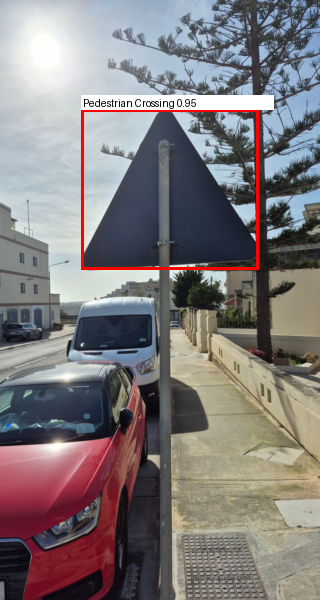

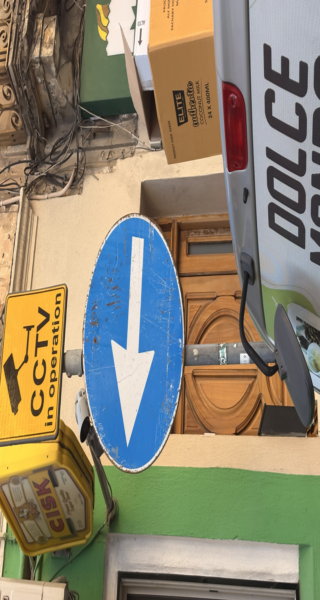

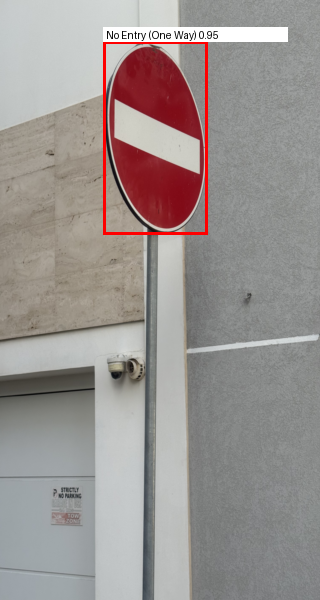

[<PIL.Image.Image image mode=RGB size=320x600>,
 <PIL.Image.Image image mode=RGB size=320x600>,
 <PIL.Image.Image image mode=RGB size=320x600>]

In [16]:
from pathlib import Path
import json
from IPython.display import display

val_dir = Path(rfdetr_root) / "valid"
ann_path = val_dir / "_annotations.coco.json"

with open(ann_path, "r", encoding="utf-8") as f:
    coco = json.load(f)

imgs = coco.get("images", [])
sel = imgs[:3] if len(imgs) >= 3 else imgs

out_imgs = []
for i, info in enumerate(sel, start=1):
    img_path = val_dir / info["file_name"]
    if not img_path.exists():
        img_path = val_dir / Path(info["file_name"]).name

    preds = rfdetr_model.predict(str(img_path), threshold=0.001)

    out_img = draw_predictions(
        img_path,
        preds,
        score_thr=0.3,
        save_path=str(Path(rfdetr_out) / f"debug_pred_vis_320_{i}.jpg"),
        rfdetr_model_for_names=rfdetr_model,
        coco_json_for_names=ann_path,
        resize_to=(320, 600),
        font_scale=0.06,
    )
    display(out_img)
    out_imgs.append(out_img)

out_imgs